In [1]:
## Toggle the code
from IPython.display import HTML
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Applied Data Scientist Excercise for Thetaray

## 1. Introduction

The dataset seems to be provided from [Lending Club Loan Data](https://www.lendingclub.com/info/download-data.action) with a subset of original features and a time span in 2014. In this report we refer to some articles from Lending Club Website like [this](https://www.lendingclub.com/public/rates-and-fees.action), to obtain some understanding of the business model that generates the data. In practice, this is more commonly done by engaging the customers directly. The technical analysis has also drawn insights from other discussions in the public domain, e.g., from [Kaggle](https://www.kaggle.com/wendykan/lending-club-loan-data/discussion).

This exercise consists of two main parts: 
- Exploratory Data Analysis focuses on the big picture of the dataset, including understanding the main factors, sanity check, descriptive statistics and some potential business related questions that can be asked about the data.
- Feature Engineering & Modelling dives into some details of one of the business problems discovered in EDA, i.e., how to predict the loan grade and thus interest rate and what features are important.

The report is generated by using [Jupyter Lab](https://github.com/jupyterlab/jupyterlab) running Python scripts. An HTML version with codes hidden is also exported as a business report.

## 2. EDA

### 2.1 Factors in Data
[Lending Club (LC)](https://www.lendingclub.com/) is an online platform enables peer-to-peer personal loans between borrowers and investors. Intuitively the three main entities involved are *borrowers*, *loans* and *investors*, with the first two directly observable in the provided dataset. Given the dataset, the interactions between these entities can be modelled in two: 
- Loan application: among other things, how the risks of the loans are captured in *loan rate*, based on the information of *borrowers* and *loans*. 
- Loan repayment: the time series of changed *loan status* along repayment.

These factors will be used as the foundation for certain assumptions about the data, which can be used for further analysis such as predictions and anomaly detections.

Based on LC website, some key concepts related to the data can be summarized as,
- A *borrower* submits a loan application online with details, specially amount and term.
- LC decides if the borrower is qualified based on the information of borrower, loan and etc.
- If it meets the requirement, LC calculates the **loan rate** based on a **grade** (a ranking system). See [how grades relate to rates.](https://www.lendingclub.com/public/rates-and-fees.action)
- A **grade** is calculated by
    - borrower information, such as FICO score, credit attributes and etc.
    - loan term
    - loan amount
    - etc
- After the loan rate is decided, the loan will be open to investors to fund. If funding is successful, the borrower will get the money and start to pay installment (usually on a monthly basis)

In this EDA, we will walk through these concepts, identify assumptions behind their relations, and validate them. Looking at these assumptions helps us decide the directions to explore in the modelling part.

In [14]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from IPython.display import display
%matplotlib inline

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier

In [2]:
## EDA helper functions

def load_df(csv_path):
    df = pd.read_csv(csv_path, dtype={"desc": np.object})
    return df

def check_na(df):
    na_count = df.isnull().sum() 
    na_percent = na_count * 100. / len(df)
    na_result = pd.DataFrame({"missing #": na_count, "missing %": na_percent.map("{:,.1f}%".format)})
    return na_result

def check_dtypes(df):
    return pd.DataFrame({"dtype": df.dtypes})

def check_unique_values(df):
    unique_count = df.apply(lambda col: len(col.unique()), axis=0)
    return pd.DataFrame({"# of unique": unique_count})

def check_top_n_values(df, n=3):
    def summarize_col(df_col):
        top_val_cnt = df_col.value_counts().head(n)
        total = len(df)
        return pd.Series({"top%i" % i: "%s (freq: %i, %.1f%%)" % (str(v), cnt, cnt*100/total) for i, (v, cnt) in enumerate(top_val_cnt.items())})
    top_val_result = [summarize_col(df[col]) for col in df.columns]
    return pd.DataFrame(top_val_result, index=df.columns)

def summarize_data(df, steps):
    summary_dfs = [step(df) for step in steps]
    summary = pd.concat(summary_dfs, axis=1)
    return summary



### 2.2 Data Summarization
First let's take a look at the big picture of the dataset.

In [3]:
# configuration
config = {
    "data_path": "../data/LoanStats3c.csv"
}

# load data
df = load_df(config["data_path"])

# basic summary
print("Data Summary:")
nrows, ncols = df.shape
print("There are %g rows and %g columns in the data" % (nrows, ncols))

## summarize columns
print("A summarization of different columns:")
steps = [check_na, check_dtypes, check_unique_values, check_top_n_values]
summarize_data(df, steps)

Data Summary:
There are 161231 rows and 52 columns in the data
A summarization of different columns:


missing # 
 missing % 
 dtype 
 # of unique 
 top0 
 top1 
 top2 
 
 
 
 
 id 
 0 
 0.0% 
 int64 
 161231 
 22552572 (freq: 1, 0.0%) 
 12428958 (freq: 1, 0.0%) 
 12846762 (freq: 1, 0.0%) 
 
 
 member_id 
 0 
 0.0% 
 int64 
 161231 
 26216447 (freq: 1, 0.0%) 
 22500800 (freq: 1, 0.0%) 
 14457738 (freq: 1, 0.0%) 
 
 
 loan_amnt 
 0 
 0.0% 
 int64 
 1268 
 10000 (freq: 11114, 6.9%) 
 12000 (freq: 8634, 5.4%) 
 15000 (freq: 8510, 5.3%) 
 
 
 funded_amnt 
 0 
 0.0% 
 int64 
 1268 
 10000 (freq: 11114, 6.9%) 
 12000 (freq: 8634, 5.4%) 
 15000 (freq: 8510, 5.3%) 
 
 
 funded_amnt_inv 
 0 
 0.0% 
 int64 
 1342 
 10000 (freq: 10302, 6.4%) 
 12000 (freq: 7877, 4.9%) 
 15000 (freq: 7612, 4.7%) 
 
 
 term 
 0 
 0.0% 
 object 
 2 
 36 months (freq: 112374, 69.7%) 
 60 months (freq: 48857, 30.3%) 
 NaN 
 
 
 int_rate 
 0 
 0.0% 
 object 
 69 
 10.99% (freq: 8472, 5.3%) 
 15.61% (freq: 8341, 5.2%) 
 12.99% (freq: 7897, 4.9%) 
 
 
 installment 
 0 
 0.0% 
 float64 
 26526 
 327.34 (freq: 764, 0.5%) 
 336.9 (freq: 625, 0.4%) 
 334.49 (freq: 594, 0.4%) 
 
 
 grade 
 0 
 0.0% 
 object 
 7 
 C (freq: 45257, 28.1%) 
 B (freq: 42811, 26.6%) 
 D (freq: 30420, 18.9%) 
 
 
 sub_grade 
 0 
 0.0% 
 object 
 35 
 C3 (freq: 9566, 5.9%) 
 C2 (freq: 9382, 5.8%) 
 B5 (freq: 9245, 5.7%) 
 
 
 emp_title 
 9183 
 5.7% 
 object 
 55439 
 Teacher (freq: 3202, 2.0%) 
 Manager (freq: 2550, 1.6%) 
 Registered Nurse (freq: 1365, 0.8%) 
 
 
 emp_length 
 7981 
 5.0% 
 object 
 12 
 10+ years (freq: 54253, 33.6%) 
 2 years (freq: 13995, 8.7%) 
 3 years (freq: 12519, 7.8%) 
 
 
 home_ownership 
 0 
 0.0% 
 object 
 4 
 MORTGAGE (freq: 83148, 51.6%) 
 RENT (freq: 62752, 38.9%) 
 OWN (freq: 15330, 9.5%) 
 
 
 annual_inc 
 0 
 0.0% 
 float64 
 13624 
 60000.0 (freq: 6222, 3.9%) 
 50000.0 (freq: 5395, 3.3%) 
 65000.0 (freq: 4803, 3.0%) 
 
 
 is_inc_v 
 0 
 0.0% 
 object 
 3 
 Source Verified (freq: 65813, 40.8%) 
 Not Verified (freq: 49109, 30.5%) 
 Verified (freq: 46309, 28.7%) 
 
 
 issue_d 
 0 
 0.0% 
 object 
 9 
 Jul-14 (freq: 29306, 18.2%) 
 May-14 (freq: 19099, 11.8%) 
 Apr-14 (freq: 19071, 11.8%) 
 
 
 loan_status 
 0 
 0.0% 
 object 
 8 
 Current (freq: 151208, 93.8%) 
 Fully Paid (freq: 6922, 4.3%) 
 Late (31-120 days) (freq: 1362, 0.8%) 
 
 
 pymnt_plan 
 0 
 0.0% 
 object 
 2 
 n (freq: 161219, 100.0%) 
 y (freq: 12, 0.0%) 
 NaN 
 
 
 url 
 0 
 0.0% 
 object 
 161231 
 https://www.lendingclub.com/browse/loanDetail.... 
 https://www.lendingclub.com/browse/loanDetail.... 
 https://www.lendingclub.com/browse/loanDetail.... 
 
 
 desc 
 146034 
 90.6% 
 object 
 14768 
 Borrower added on 03/17/14 > Debt consolidat... 
 Borrower added on 03/10/14 > Debt consolidat... 
 Borrower added on 02/19/14 > Debt consolidat... 
 
 
 purpose 
 0 
 0.0% 
 object 
 13 
 debt_consolidation (freq: 96825, 60.1%) 
 credit_card (freq: 38708, 24.0%) 
 home_improvement (freq: 9342, 5.8%) 
 
 
 title 
 0 
 0.0% 
 object 
 2052 
 Debt consolidation (freq: 94441, 58.6%) 
 Credit card refinancing (freq: 37542, 23.3%) 
 Home improvement (freq: 9173, 5.7%) 
 
 
 zip_code 
 0 
 0.0% 
 object 
 857 
 750xx (freq: 1758, 1.1%) 
 945xx (freq: 1647, 1.0%) 
 112xx (freq: 1601, 1.0%) 
 
 
 addr_state 
 0 
 0.0% 
 object 
 49 
 CA (freq: 22850, 14.2%) 
 NY (freq: 13526, 8.4%) 
 TX (freq: 13133, 8.1%) 
 
 
 dti 
 0 
 0.0% 
 float64 
 3903 
 12.0 (freq: 132, 0.1%) 
 19.2 (freq: 129, 0.1%) 
 16.8 (freq: 125, 0.1%) 
 
 
 delinq_2yrs 
 0 
 0.0% 
 int64 
 21 
 0 (freq: 128076, 79.4%) 
 1 (freq: 21602, 13.4%) 
 2 (freq: 6687, 4.1%) 
 
 
 earliest_cr_line 
 0 
 0.0% 
 object 
 627 
 Aug-01 (freq: 1357, 0.8%) 
 Aug-00 (freq: 1349, 0.8%) 
 Sep-00 (freq: 1209, 0.7%) 
 
 
 inq_last_6mths 
 0 
 0.0% 
 int64 
 7 
 0 (freq: 81745, 50.7%) 
 1 (freq: 45381, 28.1%) 
 2 (freq: 20489, 12.7%) 
 
 
 mths_since_last_delinq 
 80223 
 49.8% 
 float64 
 125 
 6.0 (freq: 1729, 1.1%) 
 13.0 (freq: 1684, 1.0%) 
 14.0 (freq: 1660, 1.0%) 
 
 
 mths_since_last_record 
 132302 
 82.1% 
 float64 
 122 
 106.0 (freq: 568, 0.4%) 
 105.0 

The summary shows important characteristics of the data, e.g.,
- % of missing values shows the general usefulness of a feature. For example, 90.6% of missing values in `desc` column makes it hard to use in any modelling practice. The same applies to column `mths_since_last_record` and `mths_since_last_major_derog`. It's also always useful to dig how missing values are generated, e.g., if it's a bug in upstream pipeline or they are generated in some systematic ways.
- Along with the feature types, # of unique values in a feature determines how it will be modelled, e.g., as numeric, ordinal or categorical. Sometimes the reported feature types are misleading so they need to be combined with other information to be useful. For example column `issue_d` (the month which the loan was funded) should be clearly converted as DateTime, and even though the dtype of `int_rate` (interest rate on the loan) is `object` (string values), a closer look at it reveals it should be modelled as numerical. Another example is `int_rate` (loan interest rate). It looks like numerical at the first place, but 69 unique values indicates that it actually has an ordinal/categorical nature. In fact we know that interest rate is highly correlcated with `grade`/`subgrade`, which are both ordinal.
- \# of unique values also shows the *granularity* of column. This information is usually useful in modelling practice. E.g., `id`, `member_id` are not directly useful when looking for similarities in data, unless when looking for anomalies. On the other side, `policy_code` and `pymnt_plan` are not useful either because they are the same for all examples.


Since the number of features in the dataset is not too big, we manage to squeeze them into one summary table. However, if the number increases, some automation should be introduced to select the features to explore, e.g., based on missing value rate and granularity.

### 2.3 Sanity Check on Assumptions

Some quick checks of the following assumptions are conducted to confirm our understanding of the business, as introduced in 2.1.

*** Assumption 1: Interest rates are highly related to loan grads/sub-grades. ***

We focus on the correlation between ranking given by LC `sub_grade` and the loan rate `int_rate`. As discovered in our previous step, we first need to convert `int_rate` to numerical and `sub_grade` as categorical. Since most of transformations in EDA are temporary, we create views of the dataset and leave the original unchanged.

Text(0.5,1,'Sub-grade and Int-rate expected to be positively correlated')

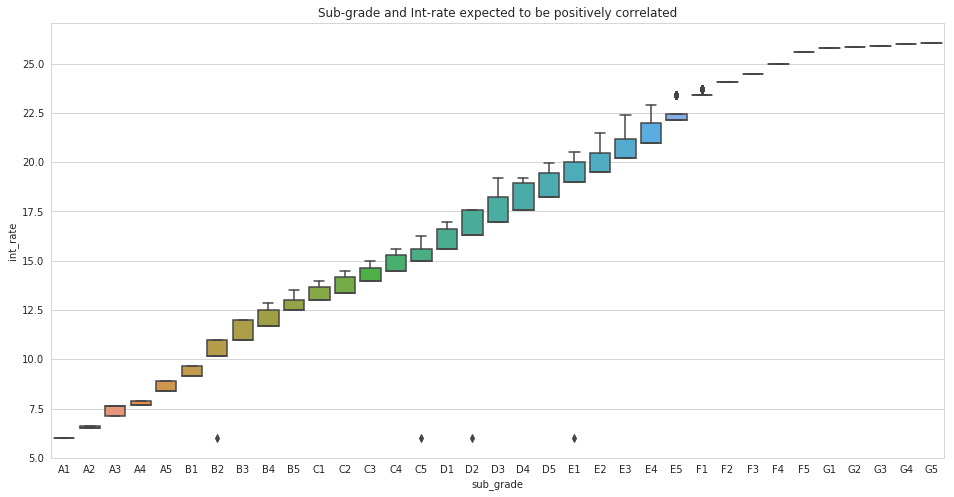

In [4]:
## View of the data frame after transformations
def rate_vs_subgrade_view(df):
    rate_vs_grade = df[["int_rate", "sub_grade", "issue_d"]].copy()
    rate_vs_grade.int_rate = rate_vs_grade.int_rate.str[:-1].astype(np.float)
    rate_vs_grade.sub_grade = pd.Categorical(rate_vs_grade.sub_grade, ordered=True)
    rate_vs_grade.issue_d = pd.to_datetime(rate_vs_grade.issue_d, format="%b-%y")
    rate_vs_grade.issue_d = rate_vs_grade.issue_d.apply(lambda d: pd.Period(year=d.year, month=d.month, freq="M"))
    return rate_vs_grade

## generate exploration view
rate_vs_grade = rate_vs_subgrade_view(df)

## subgrade vs loan rate
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.boxplot(x=rate_vs_grade["sub_grade"], y=rate_vs_grade["int_rate"], ax=ax)
ax.set_title("Sub-grade and Int-rate expected to be positively correlated")


In [5]:

## outliers

## For simplicity, we capture the outliers by setting percentile threshold for upper bound
def detect_rate_vs_subgrade_outliers(rate_vs_subgrade, upper_percentile=0.001):
    outliers = []
    for sub_grade, sdf in rate_vs_grade.groupby("sub_grade"):
        ## ignore small samples
        if sdf.shape[0] < 50: continue
        outlier_condition = sdf.int_rate <= np.percentile(sdf.int_rate, upper_percentile)
        outlier_index = sdf[outlier_condition].index
        outlier_df = df.loc[outlier_index]
        if 10 >= outlier_df.shape[0] >= 1: 
            outliers.append(outlier_df)
    return pd.concat(outliers, axis=0)

outliers = detect_rate_vs_subgrade_outliers(rate_vs_grade)
print("The outliers with lower than majority interest rates found in B2, C5, D2 and E1")
outliers.T

The outliers with lower than majority interest rates found in B2, C5, D2 and E1


41337 
 152733 
 133134 
 152899 
 
 
 
 
 id 
 21189961 
 10647408 
 12296955 
 10607397 
 
 
 member_id 
 23492872 
 12519415 
 14289091 
 12479395 
 
 
 loan_amnt 
 20000 
 6300 
 25000 
 14000 
 
 
 funded_amnt 
 20000 
 6300 
 25000 
 14000 
 
 
 funded_amnt_inv 
 20000 
 6300 
 25000 
 14000 
 
 
 term 
 60 months 
 36 months 
 36 months 
 60 months 
 
 
 int_rate 
 6.00% 
 6.00% 
 6.00% 
 6.00% 
 
 
 installment 
 387.81 
 196.83 
 773.58 
 279.83 
 
 
 grade 
 B 
 C 
 D 
 E 
 
 
 sub_grade 
 B2 
 C5 
 D2 
 E1 
 
 
 emp_title 
 Chief of Supply and Distribution 
 Land Manager 
 blocksgt 
 FORKLIFT DRIVER 
 
 
 emp_length 
 2 years 
 8 years 
 10+ years 
 7 years 
 
 
 home_ownership 
 OWN 
 RENT 
 MORTGAGE 
 MORTGAGE 
 
 
 annual_inc 
 100000 
 50000 
 85000 
 75000 
 
 
 is_inc_v 
 Source Verified 
 Source Verified 
 Source Verified 
 Source Verified 
 
 
 issue_d 
 Jul-14 
 Jan-14 
 Feb-14 
 Jan-14 
 
 
 loan_status 
 Current 
 Current 
 Current 
 Current 
 
 
 pymnt_plan 
 n 
 n 
 n 
 n 
 
 
 url 
 https://www.lendingclub.com/browse/loanDetail.... 
 https://www.lendingclub.com/browse/loanDetail.... 
 https://www.lendingclub.com/browse/loanDetail.... 
 https://www.lendingclub.com/browse/loanDetail.... 
 
 
 desc 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 purpose 
 debt_consolidation 
 debt_consolidation 
 credit_card 
 home_improvement 
 
 
 title 
 Debt consolidation 
 Debt consolidation 
 Credit card refinancing 
 Home improvement 
 
 
 zip_code 
 209xx 
 977xx 
 195xx 
 774xx 
 
 
 addr_state 
 MD 
 OR 
 PA 
 TX 
 
 
 dti 
 14.6 
 23.55 
 21.21 
 11.82 
 
 
 delinq_2yrs 
 0 
 0 
 0 
 0 
 
 
 earliest_cr_line 
 Oct-01 
 Sep-01 
 Jun-03 
 Mar-00 
 
 
 inq_last_6mths 
 2 
 0 
 3 
 3 
 
 
 mths_since_last_delinq 
 NaN 
 27 
 NaN 
 NaN 
 
 
 mths_since_last_record 
 NaN 
 27 
 NaN 
 NaN 
 
 
 open_acc 
 16 
 7 
 14 
 6 
 
 
 pub_rec 
 0 
 3 
 0 
 0 
 
 
 revol_bal 
 6556 
 11223 
 9301 
 14779 
 
 
 revol_util 
 16.10% 
 66% 
 30.90% 
 86% 
 
 
 total_acc 
 34 
 21 
 31 
 18 
 
 
 initial_list_status 
 w 
 f 
 f 
 f 
 
 
 out_prncp 
 19192.9 
 4808.02 
 20437.5 
 12692.3 
 
 
 out_prncp_inv 
 19192.9 
 4808.02 
 20437.5 
 12692.3 
 
 
 total_pymnt 
 1240.65 
 2171.25 
 7062.59 
 3373.25 
 
 
 total_pymnt_inv 
 1240.65 
 2171.25 
 7062.59 
 3373.25 
 
 
 total_rec_prncp 
 807.08 
 1491.98 
 4562.52 
 1307.74 
 
 
 total_rec_int 
 433.57 
 679.27 
 2500.07 
 2065.51 
 
 
 total_rec_late_fee 
 0 
 0 
 0 
 0 
 
 
 recoveries 
 0 
 0 
 0 
 0 
 
 
 collection_recovery_fee 
 0 
 0 
 0 
 0 
 
 
 last_pymnt_d 
 Oct-14 
 Nov-14 
 Oct-14 
 Oct-14 
 
 
 last_pymnt_amnt 
 387.81 
 196.83 
 773.58 
 374.83 
 
 
 next_pymnt_d 
 Nov-14 
 Dec-14 
 Nov-14 
 Nov-14 
 
 
 last_credit_pull_d 
 Oct-14 
 Oct-14 
 Oct-14 
 Oct-14 
 
 
 collections_12_mths_ex_med 
 0 
 0 
 0 
 0 
 
 
 mths_since_last_major_derog 
 NaN 
 NaN 
 NaN 
 37 
 
 
 policy_code 
 1 
 1 
 1 
 1

In [54]:

## distribution of rate in D3
print("Variation of interest rate within the same subgrade(e.g. D3) correlate to time periods.")
print("Below gives the # of loans grouped by int_rate and issue_d for subgrade D3.")
D3 = rate_vs_grade[rate_vs_grade.sub_grade=="D3"]
D3.groupby("int_rate").issue_d.value_counts().sort_index()

Variation of interest rate within the same subgrade(e.g. D3) correlate to time periods.
Below gives the # of loans grouped by int_rate and issue_d for subgrade D3.


int_rate  issue_d
16.99     2014-05     537
          2014-06     617
          2014-07    1265
          2014-08     719
          2014-09     351
18.25     2014-01     554
          2014-02     533
          2014-03     585
          2014-04     704
          2014-05     225
19.20     2014-01       1
Name: issue_d, dtype: int64

***Summary***

- The general trend between `loan grade` vs `loan rate` aligns with what is described on [LC's website](https://www.lendingclub.com/public/rates-and-fees.action). The relation seems to be linear.
- However, there are clearly __outliers__ in subgrades `B2`, `C5`, `D2` and `E1`. A closer check reveals that all these loans have a fixed rate as low as 6%, although there is no obvious relations among the borrowers or loans. 
- There are much less data beyond `E5`, which is also aligned with the information from LC.
- Within each subgrade, the distribution of the rates seem to be *right schewed* with a heavy tail towards higher end. This might be explained by unseen factors, e.g., the changes of rates over time or the change of calculation methods used by LC. As we discussed, interest rates can be modelled as ordinal because of its limited number of unique values. So we don't expect a Gaussian distribution here. A closer look shows that this change of interest rates within a subgrade does correlate to time.

*** Assumption 2: Grads/subgrades are correlated to borrower's information and loan's information ***

- First we will look at the distribution of subgrades. 
- One important piece of borrower's information, i.e. FICO scores, is missing in our data. So we will use "emp_length", "home_ownership", "is_inc_v", "dti", "inq_last_6mths" to represent borrowers.
- The most important features about loans are their terms and amounts. We will also use loan purpose data as well as initial_list_status (indicating whether the loan was funded initially).
- Note that the selection of features doesn't mean to be exhaustive. They are just used to gain understanding and insights during EDA. The features are selected based on their missing value% and granularity.

First, quick check of some distributions...


Text(0.5,1,'Distribution of subgrades resembles Poisson')

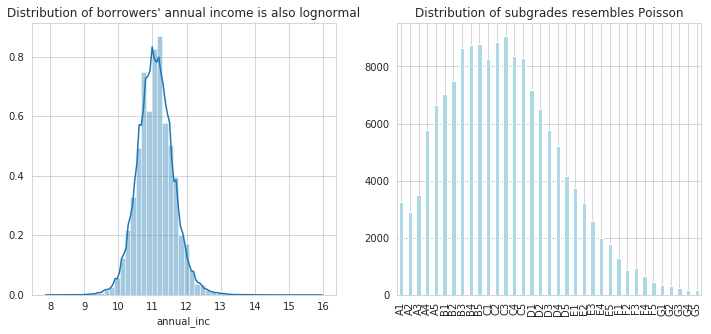

In [7]:
## generate view of data by feature transformations
## Since we have been generating more views, I refactor it to make it more general

def generate_view(df, cols_trans):
    """Apply tranformations for each (col, transform) in `cols_trans` to the dataframe `df`
    """
    cols = list(cols_trans.keys())
    view = df[cols].copy()
    for col, trans in cols_trans.items():
        if trans is not None:
            view[col] = trans(view[col])
    return view

def grade_vs_borrower_loan_view(df):
    ## columns and transactions
    target_cols2trans = {
        "sub_grade": lambda xs: pd.Categorical(xs, ordered=True)
    }
    borrower_cols2trans = {
        "emp_length": lambda xs: pd.Categorical(xs, 
                                       categories=['< 1 year','1 year','2 years','3 years',
                                                   '4 years','5 years','6 years','7 years',
                                                   '8 years','9 years','10+ years'],
                                       ordered=True), 
        "home_ownership": lambda xs: pd.Categorical(xs), 
        "is_inc_v": lambda xs: ~xs.str.contains("Not"), 
        "annual_inc": None,
        "dti": None, 
        "inq_last_6mths": None
    }
    loan_cols2trans = {
        "term": None,
        "loan_amnt": None,
        "purpose": lambda xs: pd.Categorical(xs),
        'initial_list_status': lambda xs: pd.Categorical(xs)
    }
    cols_trans = {}
    cols_trans.update(target_cols2trans)
    cols_trans.update(borrower_cols2trans)
    cols_trans.update(loan_cols2trans)
    return generate_view(df, cols_trans)

## generate the view
grade_vs_borrower_loan = grade_vs_borrower_loan_view(df)
grade_vs_borrower_loan.dropna(inplace=True)

print("First, quick check of some distributions...")
fig, axes = plt.subplots(1, 2, figsize=(2 * 6, 5))
sns.distplot(np.log(df.annual_inc), ax=axes[0])
axes[0].set_title("Distribution of borrowers' annual income is also lognormal")

grade_vs_borrower_loan.sub_grade.value_counts().sort_index().plot(kind="bar", color="lightblue", ax=axes[1])
axes[1].set_title("Distribution of subgrades resembles Poisson")

Text(0.5,1,'Distribution of sub_grades based on different groups of loan_term, loan_amount and borrower_credit')

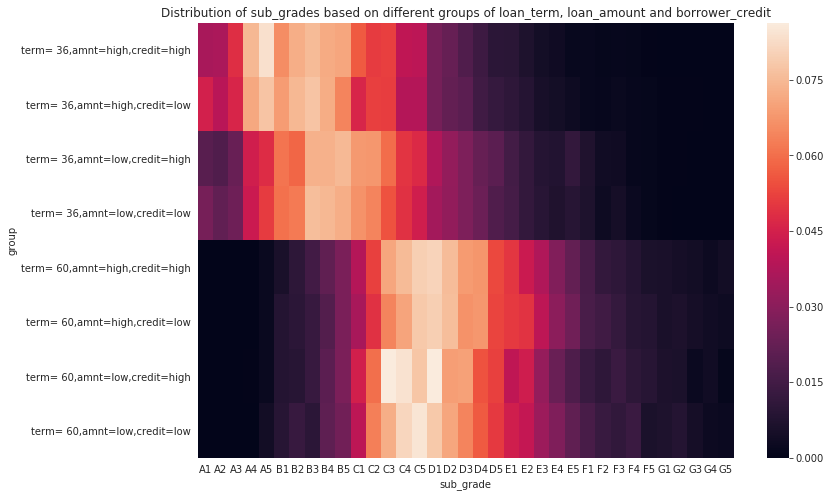

In [8]:
## feature engineering for finding borrower clusters
def borrower_cluster(borrowers):
    score = (borrowers.emp_length > '5 years').astype(np.float)
    score += (borrowers.home_ownership == 'OWN') 
    score += (borrowers.is_inc_v)
    log_inc = np.log(borrowers.annual_inc)
    score += (log_inc >= log_inc.mean())
    score += (borrowers.dti >= borrowers.dti.mean())
    score += (borrowers.inq_last_6mths <= 1)
    return pd.cut(score, bins=2, labels=["low", "high"])

def loan_amnt_cluster(loans):
    return pd.qcut(grade_vs_borrower_loan.loan_amnt, q=2, labels=["low", "high"])

def grade_vs_bl_group_view(grade_vs_borrower_loan):
    ## get groups in borrower and loan and combine them
    grade_vs_borrower_loan["borrower_credit"] = borrower_cluster(grade_vs_borrower_loan)
    grade_vs_borrower_loan["loan_amnt_cluster"] = loan_amnt_cluster(grade_vs_borrower_loan)
    grade_vs_borrower_loan["group"] = grade_vs_borrower_loan.apply(lambda r: "term=%s,amnt=%s,credit=%s" % (r["term"][:3], r["loan_amnt_cluster"], r["borrower_credit"]), axis=1)
    
    ## for each group get the normalized the distribution of sub_grade
    d = grade_vs_borrower_loan.groupby(["group"]).sub_grade.value_counts().unstack(-1).fillna(0)
    d = d.div(d.sum(axis=1), axis=0)
    return d

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.heatmap(grade_vs_bl_group_view(grade_vs_borrower_loan), ax=ax)
ax.set_title("Distribution of sub_grades based on different groups of loan_term, loan_amount and borrower_credit")

***Summary***
- The distribution of annual income from a general population is known to be lognormal. This is also observed in the borrowers.
- Grades are related to the number of times a rare event (e.g., delinquency) occurs in life time. So the distribution of grades closely resemble a Poisson distribution.
- To see how the information of borrower and loans can influence the grades, 
    - we first cluster the borrowers into "high_credit" and "low_credit" group based on information such as "emp_length", "dbi", "home_ownership" and etc. 
    - we then cluster loans based on their terms and loan_amounts.
    - from the heatmap we can clearly see that the distribution of grades is highly influenced by loan terms and then amount, specially,
        - 36-month loans tend to generate 'A'-'B' grades whereas 60-month moves it to 'C'-'D'.
        - for 36-month, the higher the loan amount, the higher the grade. But this is less significant for 60-month in our setting
    - the influnece by borrower credits is less significant, mainly because we don't have the FICO score available and the calculation of borrower scores may not be accurate. 
- We will build a machine learning model in Section 3, to verify the correlations between Grades with the information of borrowers and loans considered all together.

*** Some other quick checks ***

These are some other quick checks that focus on numerical values. They mainly serve as "sanity check" on possible errors in the data, e.g.,
- total_pymnt (total payed today) == total_rec_int (interest payed) + total_rec_prncp (principle paid) + total_rec_late_fee (late fee) + recoveries
- total_rec_prncp + out_prncp == funded_amnt

Both of them have been verified in the dataset. I excluded the codes for simplicity.

## 3. Feature Engineering & Modelling

### 3.1 Problem Definition

There are many interesting problems that can be solved by using machine learning models. Here I focus on ***finding the correlation between interest rate and other information of borrowers and loans***. I am interested in this because,
- it shows how a predictive machine learning model can be used for other tasks such as feature selection. 
- it continues the story that we left in the previous section when we try to validate our assumptions.
- it has business values - revealing the correlations may help investors to better understand how LC grading system works and make better decisions.

I leave other interesting problems to the 3.5 Next Step section for a brief discussion.

### 3.2 Feature Engineering

Unlike the ad-hoc ways of creating views in EDA, it usually benefits the machine learning practice by implementating the transformations and feature engineerings in pipelines. First it is for better reusability. It can also benefit the parameter-tunning and validation processes.

For the purpose of this exercise, I choose the same set of features that have been discussed in EDA, after we have checked their missing-value rates and granularity. Through EDA, we have known
- "int_rate" is highly predictable by "grade/sub_grade" and "issue_d", with some outliers.
- "grade/sub_grade" is correlated to the information of
    - borrowers: "emp_length", "home_ownership", "is_inc_v", "annual_inc","dti", "inq_last_6mths"
    - loans: "term", "loan_amnt", "purpose", "initial_list_status"

So we will build a predictive model with:
- inputs:  "emp_length", "home_ownership", "is_inc_v", "annual_inc","dti", "inq_last_6mths", "term", "loan_amnt", "purpose", "initial_list_status" (we need to make sure "int_rate" is excluded to avoid target leakage)
- output: "grade" (this is easier than predicting subgrade)

There might be other interesting features but using these will serve as a baseline, and improvements can be built aggressively in the future. We will use a RandomForest model for the prediction task as well as measuring the importance of features.


In details, the following transformations will be conducted with given rationals.
- "grade": we want to capture the general pattern, so we will filter out grades with small sample sizes. We will also exclude outliers discovered in EDA. Even though it has an ordinal nature, we will model it as categorical because a classification problem is generally easier to solve for most machine learning models. The class distribution is not balanced, but it is not too bad either.
- "emp_length": transformed to numercial. It can also be modelled as ordinal for tree models, but it helps reduce the input dimensionality for other models.
- "home_ownership": categorical
- "is_inc_v": categorical
- "annual_inc": transformed to log-scale. It's generally easier for most models to deal with balanced data, either inputs/outputs. Using log-scale helps to remove the heavy tail.
- "dti": numerical (it is bell shaped)
- "inq_last_6mths": numercial
- "term": categorical
- "loan_amnt", numerical, transfered to log scale
- "purpose": categorical
- "initial_list_status": categorical

Other setups:
- Normalization by standard-scaling is performed even though the RandomForest model is generally not sensitive to value ranges as other models. 
- I droped missing values for simplicity.
- We need to split the data into train and test sets. I use test_size = 0.3.
- I don't introduce hyper-parameters in the feature engineering step, although this might apply for future choices, e.g., when we quantize numerical values such as loan amount.

In [9]:
import sklearn
print("sklearn version:", sklearn.__version__)

sklearn version: 0.19.2


In [55]:
## generate data for modelling

## generate dataset for machine learning models
categorical_cols = ["home_ownership",  "is_inc_v", "term", "purpose", "initial_list_status"]
numeric_cols = ["dti", "inq_last_6mths", "emp_length", "annual_inc", "loan_amnt"]
input_cols = categorical_cols + numeric_cols
target_cols = ["grade"]

def dataset_from_raw(df):
    # exclude missing values
    dataset = df.copy().dropna(subset=input_cols+target_cols)
    # exclude sub_grades with small size
    included_grades = ["A", "B", "C", "D", "E"]
    dataset = dataset[dataset.grade.isin(included_grades)]
    # exlude known outliers 
    excluded_mbr_ids = set([23492872, 12519415, 14289091, 12479395])
    dataset = dataset[~dataset.member_id.isin(excluded_mbr_ids)]
    # convert emp_length from string to numeric
    dataset["emp_length"] = dataset.emp_length.str.replace(r"< 1", "0").str.replace("\D", "").astype(np.int)
    # log-transform for money
    dataset["annual_inc"] = np.log(dataset.annual_inc)
    dataset["loan_amnt"] = np.log(dataset.loan_amnt)
    return dataset[input_cols+target_cols].dropna()


dataset = dataset_from_raw(df)

## split data into train/test and check distribution balance
train_set, test_set = train_test_split(dataset, test_size=0.3, random_state=42)
print("First we split the dataset and keep the test set unseen from model till the last.")
print("The original data has been split into train with %d and test with %d" % (train_set.shape[0], test_set.shape[0]))

def check_grade_dist(sdf):
    counts = sdf.grade.value_counts().sort_index()
    counts = counts.div(counts.sum())
    return counts
print("Check after split, train and test sets have similiar target distribution:")
train_vs_test = pd.concat([check_grade_dist(train_set), check_grade_dist(test_set)], axis=1)
train_vs_test.columns=["train", "test"]
train_vs_test.T

First we split the dataset and keep the test set unseen from model till the last.
The original data has been split into train with 103474 and test with 44347
Check after split, train and test sets have similiar target distribution:


A 
 B 
 C 
 D 
 E 
 
 
 
 
 train 
 0.150366 
 0.274011 
 0.290440 
 0.195469 
 0.089713 
 
 
 test 
 0.147518 
 0.278260 
 0.289354 
 0.193812 
 0.091055

In [15]:
class Factorizer(BaseEstimator, TransformerMixin):
    """Factorize the categorical columns of a DF and record label mapping
    """
    def __init__(self, columns):
        self.columns = columns
        self.feature_names = None
        self.label_encoders = None
    def fit(self, X, y=None):
        self.label_encoders = {col: LabelEncoder().fit(X[col]) for col in self.columns}
        self.feature_names = ["_".join([col, label]) 
                              for col in self.columns 
                              for label in self.label_encoders[col].classes_]
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame), "factorizer accepts pd.DataFrame as input"
        labels = [self.label_encoders[col].transform(X[col]) for col in self.columns]
        return np.stack(labels, axis=1)
    
class ColumnSelector(BaseEstimator, TransformerMixin):
    """Select a set of columns of pd.DataFrame and return them as np.array
    """
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame), "columnselector accepts pd.DataFrame as input"
        return X[self.columns].values

categorical_pipeline = Pipeline([
    ("factorizer", Factorizer(categorical_cols)),
    ("one_hot", OneHotEncoder())
])
numeric_pipeline = Pipeline([
    ("selector", ColumnSelector(numeric_cols)),
    ("standarizer", StandardScaler())
])
target_pipeline = Pipeline([
    ("factorizer", Factorizer(target_cols)),
])

feature_pipleline = FeatureUnion([
    ("categorical", categorical_pipeline),
    ("numerical", numeric_pipeline),
    ("target", target_pipeline)
])

prepared_trainset = feature_pipleline.fit_transform(train_set)
prepared_testset = feature_pipleline.transform(test_set)

input_names = np.concatenate([categorical_pipeline.steps[0][1].feature_names, numeric_cols])
target_names = target_pipeline.steps[0][1].feature_names

### 3.3 Modelling

In [17]:
def Xy_from_dataset(prepared_dataset):
    X = prepared_dataset[:, :-1].toarray()
    y = prepared_dataset[:, -1].toarray().astype(np.int32).squeeze()
    return X, y

train_X, train_y = Xy_from_dataset(prepared_trainset)
test_X, test_y = Xy_from_dataset(prepared_testset)


Before we fit models to capture more complicated relations between inputs and outputs, let's first take a look at the linear correlation between the target output "grade" and different generated features. Just as we have observed in EDA, the important features are,
- loan terms, specially, changing from 36 months to 60 months tends to increase the grade.
- whether the income is verfied 
- loan purpose, specially credit_card seems to bring down the grade and debt_consolidation will increase it.
- inq_last_6mths
- dti
- annual_inc

Note that the linear correlation is a sufficient but not necessary condition for two variables to be dependent. Using a machine learning model such as Random Forest will help evaluate the feature importances in a complicated way.

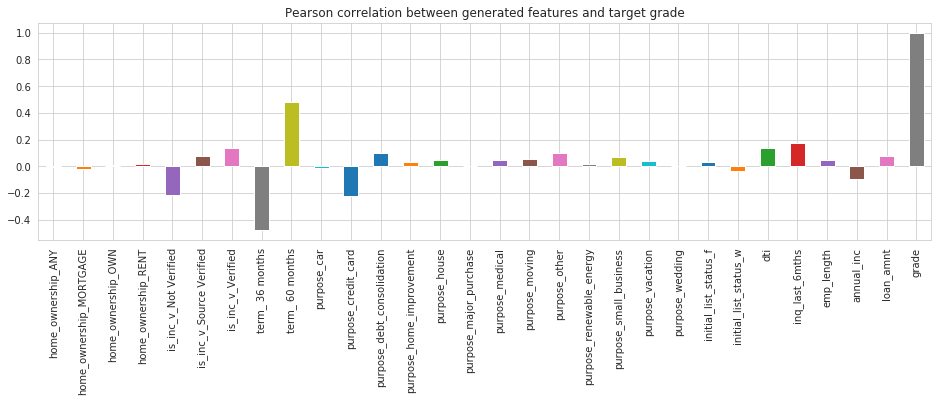

In [23]:
corr_with_target = pd.DataFrame(prepared_trainset.toarray(), columns=list(input_names)+["grade"]).corr(method="pearson").grade
corr_with_target.plot(kind="bar", figsize=(16, 4), title="Pearson correlation between generated features and target grade")

In [0]:
## modelling and hyper parameter tunning
param_grid = {
    "bootstrap": [False, True],
    "n_estimators": [50, 100, 200, 500],
    "max_depth": [3, 5, 10, 15, 20], 
    "max_leaf_nodes": [100, 200, 400, 500, None]}

base_model = RandomForestClassifier(oob_score=False)
search = RandomizedSearchCV(base_model, param_grid, cv=3, n_jobs=7, scoring='accuracy', n_iter=100, verbose=2)
search.fit(train_X, train_y)

To achieve the optimal generalization performance, we use random-search to tune the hyper-parameters of the Random Forest model, i.e., # of estimators in the ensemble, complexity of individual tree and whether to use bootstrap. In the search, we use 3-fold cross validation to avoid overfit. The final results show that accuracy on a separate test set is 41.5%, which is very close to the cross-validation estimate 41.2%. This indicates our model is not overfitted. On the other hand, since our setup of hyperparameter space is big enough to contain very complicated model, the likelihood of having an underfitting model is also very low.

Footnote: In the above search, it might deserve some further exploration on some parameters e.g., "n_estimator" and "max_leaf_nodes", because their optimal values are on the exploration boundary (=500).

In [45]:
print("The best hyper-parameters found in the search: ", search.best_params_)
print("The best 3-fold CV accuracy found in the search: ", search.best_score_)
print("The accuracy on the test set by the best estimator:", search.score(test_X, test_y))

The best hyper-parameters found in the search:  {'n_estimators': 500, 'max_leaf_nodes': 500, 'max_depth': 15, 'bootstrap': False}
The best 3-fold CV accuracy found in the search:  0.4162011713087346
The accuracy on the test set by the best estimator: 0.4190136875098654


Now let's take a look at the final result in terms of confusion matrix and featuren importances.

In [56]:
def confumsion_matrix(y, yhat, target_names):
    y = np.array([target_names[label] for label in y])
    yhat = np.array([target_names[label] for label in yhat])
    result = pd.DataFrame({"truth": y, "prediction": yhat})
    cm = pd.pivot_table(result, index="truth", columns="prediction", aggfunc="size")
    cm = cm.div(cm.sum(axis=1), axis=0).fillna(0)
    return cm

test_yhat = search.best_estimator_.predict(test_X)
cm = confumsion_matrix(test_y, test_yhat, target_names)
cm

prediction 
 grade_A 
 grade_B 
 grade_C 
 grade_D 
 grade_E 
 
 
 truth 
 
 
 
 
 
 
 
 
 
 grade_A 
 0.250535 
 0.665240 
 0.083155 
 0.001070 
 0.000000 
 
 
 grade_B 
 0.084198 
 0.634927 
 0.253323 
 0.027472 
 0.000081 
 
 
 grade_C 
 0.022366 
 0.356998 
 0.452852 
 0.167082 
 0.000701 
 
 
 grade_D 
 0.005003 
 0.178010 
 0.436417 
 0.377545 
 0.003025 
 
 
 grade_E 
 0.001486 
 0.102526 
 0.369985 
 0.513125 
 0.012878

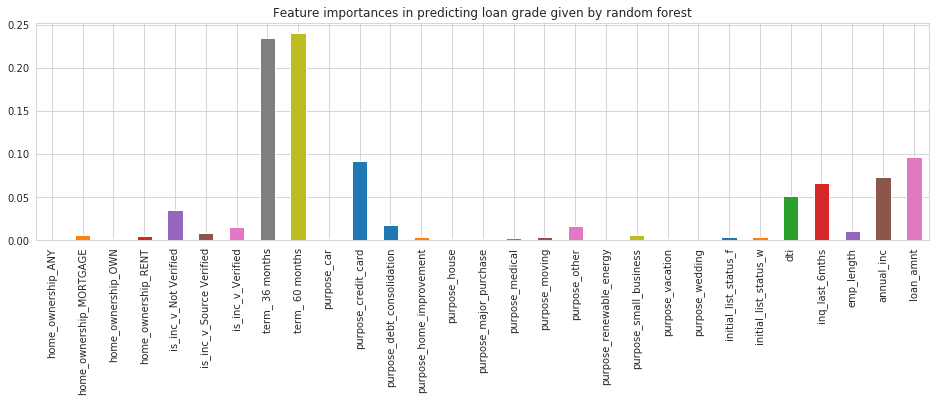

In [51]:
feat_importances = pd.Series(search.best_estimator_.feature_importances_, index=input_names)
feat_importances.plot(kind="bar", figsize=(16, 4), title="Feature importances in predicting loan grade given by random forest")




### 3.4 Conclusion

From the confusion matrix, we can see that the model does a relatively better job on predicting grade_B and grade_C. Its performance on grade_A and grade_D are also better than random guess. It doesn't do well on recognizing grade_E. Recall this result concides with the observation we made in EDA where grade_B and grade_C are majorities, and basically the features can only help distinguish these two. 

In terms of feature importances, the result given by training a random forest is similiar to those by pearson correlation. These most important features remain the same such as loan term, used for credit card, loan amount, income, inq_last_6mths, and whether the income source is verified. Intuitively this says that the relations between these features and the target are generally simple and can even be captured in a linear model. It makes sense because it is more likely that LC prefers such an explainable model than a complicated blackbox.

A classification accuracy of 41% may not be very impressive as a prediction result. It says that some important features may be lacking in our dataset, such as the FICO scores. On the other hand, the model is useful in our analysis because it clearly speculates the important factors that are related to a loan grade and thus its interest rate. This helps to verify our understanding of the data. It also serves as a baseline model for further explorations.

### 3.5 Next Step
- the above EDA is not exhaustive, so other checks should be conducted in the future, e.g., 
    - geo-distribution of loans applications
    - time series of loan applications
    - distribution of loan status
    - demography of borrowers
- for predictive analyis, 
    - it is useful to predict the status of loans, specially the likelihood of default. There have been a lot of works on this in the literature such as [this article](https://www.kaggle.com/pragyanbo/a-hitchhiker-s-guide-to-lending-club-loan-data). detection.
    - it is also interesting to predict when a loan will default.
- for anomaly detection,
    - although there is no redundant member_id in the dataset, it will be interesting to find "similar" borrowers, e.g., borrowers with smiliar title, employee info, income, address, creding lines and etc. A possible next step is to identify whether they are actually the same people.
    - there is a high interest to predict "fraud" from both investors and LC's perspectives. In one case, it is interesting to find any loans that default within a short term, e.g., < 3 months. This can be done by filtering on (last_pymnt_d - issue_d) < thr and status.isin([ 'Charged Off', 'Default']).
    - on the other side, it is also interesting to find people/loans where a "fully paid" happened within a short period. This may be used in applications such as money-laundering detections.